In [1]:
# import modules
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import random
from torch.utils.data import DataLoader, TensorDataset
from pandas import DataFrame
from torch import Tensor

In [2]:
import pandas as pd

def ReadFile(filename):
       return pd.read_csv(filename)

def ShrinkData(data):

       return data[["Points", "Goals", "Assists", "CleanSheets", "Saves", "BonusPoints", 'PointsInLastFive',
              'MinutesInLastFive', 'GoalsInLastFive', 'xGoalsInLastFive',
              'xAssistsInLastFive', 'CleanSheetsInLastFive',
              'GoalsConcededInLastFive', 'xGoalsConcededInLastFive',
              'SavesInLastFive', 'BonusPointsInLastFive',
              'BonusPointsRatingInLastFive','OpponentGoalsScoredInLastFive',
              'OpponentGoalsConcededInLastFive']]


data = ReadFile('Data/TrainingData.csv')
datarows = ShrinkData(data)
       
# Split the data into a training and testing set
rows = datarows.shape[0]
columns = datarows.shape[1]
print(rows, columns)



columns = datarows.shape[1]
playerIds = data["Id"].values
actual_values = data['ActualPoints'].values

X = np.array(datarows)
y = np.array(actual_values)

9825 19


In [3]:
models = []

In [4]:

import torch.nn as nn
import torch.optim as optim
# Define the model
model = nn.Sequential(
    nn.Linear(columns, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 24),
    nn.ReLU(),
    nn.Linear(24, 1)
)


lr = 0.01
betas = [0.9, 0.999]
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas) # lr=0.0001

In [5]:
# restore model state
model.load_state_dict(torch.load("model_parameters"))
model.eval()

Sequential(
  (0): Linear(in_features=19, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)

In [5]:

import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# train-test split of the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Standardizing data
# scaler = StandardScaler()
# scaler.fit(X_train_raw)
# X_train = scaler.transform(X_train_raw)
# X_test = scaler.transform(X_test_raw)

X_train = torch.tensor(X_train_raw, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_raw, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 3000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):

    if epoch % 100 == 0:
        print(epoch)

    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

models.append((best_weights, best_mse, n_epochs, batch_size))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [24]:
# save model to file
torch.save(model.state_dict(), "model-parameters-results")


MSE: 7.17
RMSE: 2.68


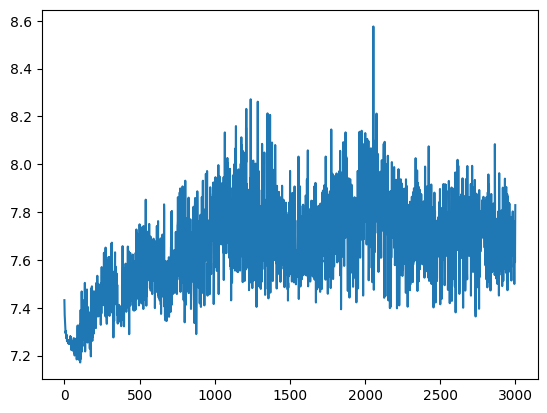

In [6]:
import matplotlib.pyplot as plt

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [23]:
model.eval()
with torch.no_grad():
    blank_total, blank_correct, return_total, return_correct = 0,0,0,0

    bad_guess = 0
    diffs = [0,0,0,0,0,0]
    # Test out inference with 5 samples
    for i in range(len(X_test_raw)):
        X_sample = X_test_raw[i: i+1] # to make 2d array
        # X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)[0].numpy().item(0)
        y_actual = y_test[i].numpy().item(0)

        y_pred = round(y_pred)
        diff = int(abs(y_pred - y_actual))
        print(int(diff))
        if diff > 5:
            bad_guess += 1
        else:
            diffs[diff] += 1
            
        if y_actual > 5:
            return_total += 1
            if y_pred > 3:
                return_correct += 1
        else:
            blank_total += 1
            if y_pred <= 3:
                blank_correct += 1
        print(f" -> {y_pred} (expected {y_actual})") # {X_test_raw[i]}
        # print(f"unnormalize {scaler.inverse_transform(y_pred[0].reshape(-1, 1).numpy())}")
    print(blank_correct / blank_total, return_correct / return_total, blank_total, return_total)
    print(bad_guess, diffs)


1
 -> 3 (expected 2.0)
1
 -> 1 (expected 2.0)
1
 -> 1 (expected 0.0)
0
 -> 1 (expected 1.0)
2
 -> 2 (expected 0.0)
5
 -> 3 (expected 8.0)
0
 -> 2 (expected 2.0)
2
 -> 4 (expected 2.0)
2
 -> 2 (expected 0.0)
1
 -> 2 (expected 1.0)
1
 -> 1 (expected 0.0)
0
 -> 0 (expected 0.0)
0
 -> 1 (expected 1.0)
1
 -> 0 (expected 1.0)
3
 -> 3 (expected 0.0)
1
 -> 3 (expected 4.0)
1
 -> 1 (expected 0.0)
3
 -> 3 (expected 0.0)
0
 -> 0 (expected 0.0)
2
 -> 2 (expected 0.0)
3
 -> 3 (expected 0.0)
1
 -> 1 (expected 0.0)
1
 -> 3 (expected 2.0)
1
 -> 3 (expected 2.0)
0
 -> 0 (expected 0.0)
0
 -> 0 (expected 0.0)
2
 -> 2 (expected 0.0)
0
 -> 0 (expected 0.0)
1
 -> 0 (expected 1.0)
3
 -> 4 (expected 1.0)
1
 -> 1 (expected 0.0)
1
 -> 1 (expected 0.0)
0
 -> 1 (expected 1.0)
3
 -> 3 (expected 0.0)
1
 -> 3 (expected 4.0)
4
 -> 2 (expected 6.0)
2
 -> 2 (expected 0.0)
0
 -> 1 (expected 1.0)
3
 -> 2 (expected 5.0)
0
 -> 2 (expected 2.0)
1
 -> 2 (expected 1.0)
1
 -> 1 (expected 2.0)
0
 -> 0 (expected 0.0)
1
 -> 3 (ex

In [11]:
import csv
def WriteToCsv(arr, filename):

    with open(filename, 'w', encoding="utf-8", newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')

        writer.writerow(["Id", "Name", "Prediction"])
        for i in arr:
            writer.writerow(i)
    


In [18]:
test_data = ReadFile("Data/TestingData-Week34.csv")

ids = test_data["Id"]
names = test_data["Name"]
team = test_data["Team"]
test_shrink = np.array(ShrinkData(test_data))

test_tensor = torch.tensor(test_shrink, dtype=torch.float32)

rows = test_shrink.shape[0]

results = []

# test model on data
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(rows):
        X_sample = test_tensor[i: i+1] # to make 2d array

        # X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        # print(f" -> {y_pred[0].numpy()} from {ids[i]}, {names[i]}") # {X_test_raw[i]}

        # do an operation for the weekly challenge
        # 32: double manu + liverpoool player points
        scalar = 1
        # if names[i] == "Gudmundsson":
        #     print(ids[i], X_sample, y_pred)
        # scalar = 2 if team[i] in ["Liverpool", "ManUtd"] else 1
        # 34: double points for relegation teams
        scalar = 2 if team[i] in ["Luton", "Burnley", "SheffieldUtd"] else 1
        results.append([ids[i], names[i], (scalar * y_pred[0].numpy())[0]])
        # print(f"unnormalize {scaler.inverse_transform(y_pred[0].reshape(-1, 1).numpy())}")


In [19]:
WriteToCsv(results, "Data/Predictions-Week34.csv")

In [13]:
# for i in range(len(results)):
#     results[i][2] = results[i][2][0]

In [60]:
# predict next gameweek
data = pd.read_csv('Data/TrainingData-Week27.csv')


datarows = data[["Points", "Goals", "Assists", "CleanSheets", "Saves", "BonusPoints", 'PointsInLastFive',
       'MinutesInLastFive', 'GoalsInLastFive', 'xGoalsInLastFive',
       'xAssistsInLastFive', 'CleanSheetsInLastFive',
       'GoalsConcededInLastFive', 'xGoalsConcededInLastFive',
       'SavesInLastFive', 'BonusPointsInLastFive',
       'BonusPointsRatingInLastFive','OpponentGoalsScoredInLastFive',
       'OpponentGoalsConcededInLastFive']]

actual_values = data['ActualPoints'].values

X = np.array(datarows)
Y = np.array(actual_values)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32).reshape(-1, 1)

model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for x, y in zip(X, Y):
        # print(x, y)
        
        y_pred = model(x)
        print(f" -> {y_pred[0].numpy()} (expected {y.numpy()})")

 -> 1.5061432123184204 (expected [1.])
 -> 9.221017837524414 (expected [6.])
 -> 7.6226091384887695 (expected [14.])
 -> 0.30423545837402344 (expected [1.])
 -> 1.944525957107544 (expected [3.])
 -> 4.685642242431641 (expected [10.])
 -> 8.400630950927734 (expected [11.])
 -> 1.65179443359375 (expected [0.])
 -> 2.5160958766937256 (expected [10.])
 -> 1.0111321210861206 (expected [1.])
 -> 1.7932178974151611 (expected [0.])
 -> 2.5160958766937256 (expected [7.])
 -> 12.106894493103027 (expected [6.])
 -> 1.743091344833374 (expected [0.])
 -> 1.6981956958770752 (expected [0.])
 -> 2.5160958766937256 (expected [1.])
 -> 13.659329414367676 (expected [13.])
 -> 1.5704729557037354 (expected [0.])
 -> 4.752765655517578 (expected [6.])
 -> 2.5160958766937256 (expected [8.])
 -> 0.0488584041595459 (expected [0.])
 -> 2.5160958766937256 (expected [4.])
 -> 3.005648612976074 (expected [1.])
 -> 0.03705167770385742 (expected [0.])
 -> 1.6343555450439453 (expected [0.])
 -> 0.78950035572052 (expec